In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from shapely import Polygon,Point,MultiPoint,LineString
from scipy.spatial import ConvexHull
from itertools import combinations
from shapely.ops import unary_union
from IPython.display import display, clear_output
from matplotlib import animation
from sympy import symbols
import numpy.matlib
def getPotRegions(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [X[i][0]-imp, X[i][1]+imp]
        Bx[i,1,:]= [X[i][0]+imp, X[i][1]+imp]
        Bx[i,2,:]= [X[i][0]+imp, X[i][1]-imp]
        Bx[i,3,:]= [X[i][0]-imp, X[i][1]-imp]
    return(Bx);
def getPotRegions_var(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [X[i][0]-imp[i], X[i][1]+imp[i]]
        Bx[i,1,:]= [X[i][0]+imp[i], X[i][1]+imp[i]]
        Bx[i,2,:]= [X[i][0]+imp[i], X[i][1]-imp[i]]
        Bx[i,3,:]= [X[i][0]-imp[i], X[i][1]-imp[i]]
    return(Bx);
def CPIH_Safepoint(n,Bx,Xi):
    k = int(np.floor(2/3*n)+1);
    n = np.arange(n);

    combk = list(combinations(n,k));
    safeX = [];
    safeY =[];
    first= True;
    CPIH= Polygon();
    #testing
   
    for C in combk:
        if Xi in C:
            comb3 = list(combinations(C,3));
            dp1 =[];
            Chull = Polygon();
            for i in range(len(comb3)):
                comb2 = list(combinations(comb3[i][:],2))
                b1 = int(comb3[i][0]);
                b2 = int(comb3[i][1]);
                b3 = int(comb3[i][2]);
                dp1 = np.vstack((Bx[b1,:,:],Bx[b2,:,:],Bx[b3,:,:]));
                idx = ConvexHull(dp1);
                dp1 = Polygon(dp1[idx.vertices,:]);
                dp2 = Polygon();
                for j in range(len(comb2)):
                    a1 = comb2[j][0];
                    a2 = comb2[j][1];
                    temp= np.vstack((Bx[a1,:,:],Bx[a2,:,:]));
                    idx = ConvexHull(temp);
                    temp =  Polygon(temp[idx.vertices,:]);
                    dp2 = unary_union([dp2,temp])
                diff = dp1.difference(dp2);
                Chull= unary_union([Chull,diff]);


            if (first and not Chull.is_empty):
                CPIH = Polygon(Chull.convex_hull);

            else:
                #NEW 
                if not Chull.is_empty:
                    Chull = Polygon(Chull.convex_hull);
                #ENDNEW
                CPIH = CPIH.intersection(Chull);
                if not CPIH.geom_type == 'Polygon' and not CPIH.is_empty:

                    for member in CPIH.geoms:
                        if member.geom_type == 'Polygon':
                            CPIH = member;


                if CPIH.is_empty:
                    return [0,0];
                    break;
            first = False;
    safeX,safeY = np.array(CPIH.exterior.xy)
        #safeX.append(x);
        #safeY.append(y);
    return [safeX,safeY];
    #return CPIH
def maxDist(Xi,safeX,safeY):
    max_dist = 0;
    max_indx = [];
    for i in range(len(safeX)):
        norm = np.linalg.norm(Xi-[safeX[i],safeY[i]]);
        if norm> max_dist:
            max_dist = norm;
            max_indx = [];
            max_indx.append(i);
        elif norm == max_dist:
            max_indx.append(i);
            
    return [np.mean(safeX[max_indx]),np.mean(safeY[max_indx])],max_dist;
def minOrthProj(Xi,Xj,X):
    JI = Xj-Xi;
    mindist = 100;
    for i in range(len(X))-1:
        if any(X[i] != Xi) and any(X[i] != Xj):
            AB = X[i]-Xi;
            
            AB_orth = np.array([-AB[1],AB[0]]);
            alt = np.linalg.norm(np.dot(AB_orth,JI)/pow(np.linalg.norm(AB_orth),2)*AB_orth);
            if alt < mindist:
                mindist = alt;
    return mindist;
def ExtractX(lst,i):
    return [item[i][0] for item in lst]
def ExtractY(lst,i):
    return [item[i][1] for item in lst]

def plothull(X):
    hull = ConvexHull(X);
    hullx = np.append(X[hull.vertices,0],X[hull.vertices[0],0]);
    hully = np.append(X[hull.vertices,1],X[hull.vertices[0],1]);
    plt.plot(hullx,hully);
def calcsafepoint(n,Bx):
    n = np.arange(n);
    comb3 = list(combinations(n,3));
    safeX = [];
    safeY =[];
    dp1 =[]
    for i in range(len(comb3)):
        comb2 = list(combinations(comb3[i][:],2))
        b1 = int(comb3[i][0]);
        b2 = int(comb3[i][1]);
        b3 = int(comb3[i][2]);
        dp1 = np.vstack((Bx[b1,:,:],Bx[b2,:,:],Bx[b3,:,:]));
        idx = ConvexHull(dp1);
        dp1 = Polygon(dp1[idx.vertices,:]);
        dp2 = Polygon();
        for j in range(len(comb2)):
            a1 = comb2[j][0];
            a2 = comb2[j][1];
            temp= np.vstack((Bx[a1,:,:],Bx[a2,:,:]));
            idx = ConvexHull(temp);
            temp =  Polygon(temp[idx.vertices,:]);
            dp2 = unary_union([dp2,temp])
        diff = dp1.difference(dp2);
        x,y = np.array(diff.exterior.xy)
        safeX.append(x);
        safeY.append(y);
    return [safeX,safeY]; 

In [2]:
def WMSR(X,i):
    minx = min(X[:,0])
    maxx = max(X[:,0])
    miny = min(X[:,1])
    maxy = max(X[:,1])
    targetx = [];
    targety = [];
    num = len(X)-2;
    for n in range(len(X)):
        
        if X[n][0]!= minx and X[n][0] != maxx or n ==i:
            targetx.append(X[n][0])
        if X[n][1]!= miny and X[n][1] != maxy or n ==i:
            targety.append(X[n][1])
    if i<3:
        targetx = min(targetx)
        targety = min(targety)
    else:
        targetx = max(targetx)
        targety = max(targety)
    return np.array((targetx,targety))

        

In [3]:
def attackerWMSR(X,n):
    minx = min(X[:,0])
    maxx = max(X[:,0])
    miny = min(X[:,1])
    maxy = max(X[:,1])
    targetx = 0;
    targety = 0;
    if n>2:
        targetx = maxx-0.1
        targety = maxy-0.1
    else:
        targetx = minx+0.1
        targety = maxy-0.1
    return np.array((targetx,targety))


In [4]:
def getPotRegions_var2(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [float(X[i][0]-imp), float(X[i][1]+imp)]
        Bx[i,1,:]= [float(X[i][0]+imp), float(X[i][1]+imp)]
        Bx[i,2,:]= [float(X[i][0]+imp), float(X[i][1]-imp)]
        Bx[i,3,:]= [float(X[i][0]-imp), float(X[i][1]-imp)]
    return(Bx);

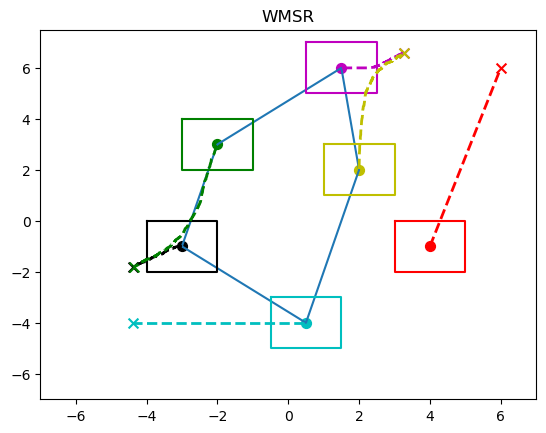

In [10]:
fig, ax = plt.subplots()
#fig2,ax2 = plt.subplots()
#fig3,ax3 = plt.subplots()
#fig4,ax4 = plt.subplots()
#fig5,ax5 = plt.subplots()
#fig6,ax6 = plt.subplots()
#axlist= [ax,ax2,ax3,ax4,ax5,ax6]
#figlist = [fig,fig2,fig3,fig4,fig5,fig6]
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(2,2),(4,-1)]);
#X = np.array([(-3,-1), (-3, 4),(0.5 ,-4),(1.5,6),(3.5,2),(4,-1)]);
#offset = np.ones((6,2))*.5;
offset = np.ones((8,2))*.5;
#X= 12*(np.random.rand(6,2)-offset)
Xn = np.zeros((6,6,2));
#Xn = np.zeros((8,8,2))
Xn[:]= X;
n = len(X);
#imp = .5*np.ones((6,6))-.5*np.eye(6);
imp = .4*np.ones((6,1));
colors= ['k','g','c','m','y','r'];
empty = False;

frames = [];
step = 0;
emptyCPIH = np.zeros((6,1));
Xhist = [];
Yhist = [];
hull = ConvexHull(X[0:5]);
xplot = [];
yplot = [];
ham = 0;
attackerTarget = np.array((6,6))
for v in hull.vertices:
    xplot.append(X[v,0]);
    yplot.append(X[v,1]);
xplot.append(X[hull.vertices[0],0]);
yplot.append(X[hull.vertices[0],1]);
ax.plot(xplot,yplot,label = 'Conv('+r'$X_0$'+')');
for i in range(5):
    lbl = r'Agent '+str(i+1);
    ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);
ax.scatter(X[5,0],X[5,1],c= colors[5], marker = 'o',label = r'Attacker',s = 50);
maxdist = np.zeros((1,602))
target = np.zeros((n,2));
targetdist=np.zeros((n,1));
snapshot= (0,80,160,240,300,600)
imphist = [];
while not empty:
   
    #ax.cla();
   # ax.set_xlim(-7,7);
   # ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;

    for i in range(n):
        for j in range(n):
                #imp[i][j] = mindist/(6);
                #Xn[i][j] = X[j]+2*imp[i][j]*(np.random.rand(1,2)-.5);
                Xn[i][j] = X[j]+2*(np.random.rand(1,2)-.5);
      
        Xn[i][n-1]= attackerWMSR(Xn[i],i)
        Xn[i][i]  = X[i];
        if i!= n-1:
            #Bx = getPotRegions_var(Xn[i],imp[i][:]);
            Bx = getPotRegions_var2(Xn[i],1)
        if step ==0 and i == 0:          
              #  minplotvar1 =100;
#                 for l in range(1,n):
#                     if l == 0:
#                         plotvar1 = minOrthProj(X[0],X[l],X)
#                     if plotvar1< minplotvar1:
#                         minplotvar1 = plotvar1;
                impplot = imp.copy();
               # impplot[0][0] =  minplotvar1/3;
               # Bxplot = getPotRegions_var(X,impplot[0][:])    
                Bxplot = getPotRegions_var2(X,1);#getPotRegions_var2(X,impplot[:])    
                for l in range(n):
                    x = []; y = [];
                    for k in range(4):
                        x.append(Bxplot[l,k,0]);
                        y.append(Bxplot[l,k,1]);
                    x.append(Bxplot[l,0,0]);
                    y.append(Bxplot[l,0,1]);
                    #ax.plot(x,y,c= colors[l]);
                    ax.plot(x,y,c=colors[l]);
                    #axlist[ham].plot()
                
                if ham <0:
                    axlist[ham].plot(xplot,yplot,label = 'Conv('+r'$X_0$'+')');
                    for i in range(5):
                        lbl = 'Agent '+str(i+1);
                        axlist[ham].scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);
                    axlist[ham].scatter(X[5,0],X[5,1],c= colors[5], marker = 'o',label = r'Attacker',s = 50);
                ham = ham+1;
        #if i != n-1 and emptyCPIH[i] == 0:
        if i != n-1:
            #safeX,safeY = CPIH_Safepoint(n,Bx,i);
            target[i]= WMSR(Xn[i],i);
        elif i== n-1:
            target[i] = attackerTarget
       
                
        

    for i in range(n-1):
        X[i]= X[i]+dt*(target[i]-X[i]);

        #X[i]= X[i]+dt*(target[i]);
    Xhist.append(X.copy());
    X[n-1] = X[n-1]+dt*(target[n-1]-X[n-1]);
    
    
    if step>600 or any(emptyCPIH == 1):
        empty = True;
   # fig.canvas.draw()
    #fig.canvas.flush_events();
    #display(fig);
  
    for i in range(5):
        for j in range(5):
            temp = np.linalg.norm(X[i]-X[j]);
            if temp> maxdist[0][step]:
                maxdist[0][step] = temp;
    step +=1;

for i in range(6):
    xplot = ExtractX(Xhist,i);
    yplot = ExtractY(Xhist,i);
    endn = len(xplot);
    ax.plot(xplot,yplot,c = colors[i],linestyle='dashed',linewidth= 2);
    ax.scatter(xplot[endn-1],yplot[endn-1],c = colors[i], marker='x',s=50);
ax.set_xlim(-7,7);
ax.set_ylim(-7,7.5);
# i = 0;
# for axis in axlist:
#     axis.set_xlim(-7,7);
#     axis.set_ylim(-7,7);
#     leg=axis.legend();
#     axis.set_title('DB-CPIH, t = '+str(snapshot[i]));
#     i= i+1;
#leg = ax.legend();
plt.title('WMSR');
plt.savefig("WMSR_trajectories.jpg")
#plt.savefig("WMSR_trajectories.fig")
#ax.scatter(minimalhull[0],minimalhull[1]);
# i = 0;
# for f in figlist:
#     display(f);
#     f.savefig("DB-CPIH_Snapshot"+str(i)+".jpg")
#     i = i+1

In [6]:
print(X)

[[-4.4723835  -1.73543932]
 [-4.50372971 -1.80592992]
 [-4.48994378 -4.        ]
 [ 3.2555689   6.58019887]
 [ 3.2118202   6.53638406]
 [ 5.9952857   5.98349995]]


In [21]:
print(max(X[:,0]))

9.019706116667173
